# Hybrid Tensorial Neural Network model

This is an example of how one can combine tensor networks and neural networks
to build hybrid models. We will create a convolutional layer whose output will be
given to 4 MPS layers in different orderings. This model was introduced in [[GPC20']](https://arxiv.org/abs/1806.05964)

In [ ]:
%mkdir data
%mkdir models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import tensorkrowch as tk

In [2]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

## Dataset

In [3]:
# FashionMNIST Dataset
dataset_name = 'fashion_mnist'
batch_size = 64
image_size = 28
input_size = image_size ** 2
num_classes = 10

# Load data
train_dataset = datasets.FashionMNIST(root='data/',
                                      train=True,
                                      transform=transforms.ToTensor(),
                                      download=True)
test_dataset = datasets.FashionMNIST(root='data/',
                                     train=False,
                                     transform=transforms.ToTensor(),
                                     download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

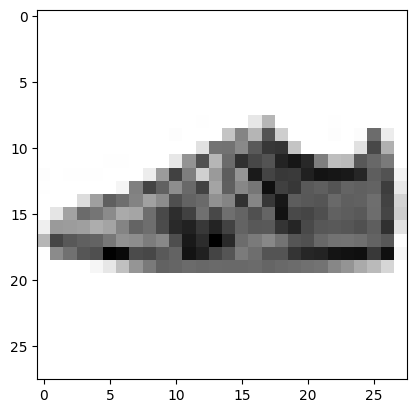

7


In [4]:
random_sample = torch.randint(low=0, high=len(train_dataset), size=(1,)).item()

plt.imshow(train_dataset[random_sample][0].squeeze(0), cmap='Greys')
plt.show()

print(train_dataset[random_sample][1])

## Define model

In [5]:
class CNN_SnakeSBS(nn.Module):
    
    def __init__(self,
                 in_channels,
                 bond_dim,
                 image_size,
                 num_classes,
                 init_method,
                 inline_input,
                 inline_mats,
                 renormalize,
                 *args,
                 **kwargs):
        super().__init__()
        
        # image = batch_size x in_channels x 28 x 28
        self.cnn = nn.Conv2d(in_channels=in_channels,
                             out_channels=6,
                             kernel_size=5,
                             stride=1,
                             padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)  # 6 X 14 x 14
        
        self.mps_layers = nn.ModuleList()
        for _ in range(4):
            mps = tk.models.ConvMPSLayer(in_channels=7,
                                         bond_dim=bond_dim,
                                         out_channels=num_classes,
                                         kernel_size=image_size // 2,
                                         init_method=init_method,
                                         *args,
                                         **kwargs)
            self.mps_layers.append(mps)
        
        self.inline_input = inline_input
        self.inline_mats = inline_mats
        self.renormalize = renormalize
    
    @staticmethod
    def embedding(x):
        ones = torch.ones_like(x[:, :1])
        return torch.cat([ones, x], dim=1)
        
    def forward(self, x):
        x = self.relu(self.cnn(x))
        x = self.pool(x)
        x = self.embedding(x)
        
        flips_x = [x, x.transpose(2, 3), x.flip(2), x.transpose(2, 3).flip(2)]
        lst_ys = []
        for i in range(4):
            y = self.mps_layers[i](flips_x[i],
                                   mode='snake',
                                   inline_input=self.inline_input,
                                   inline_mats=self.inline_mats,
                                   renormalize=self.renormalize)
            lst_ys.append(y)
        
        y = torch.stack(lst_ys, dim=0)
        y = y.prod(dim=0).view(-1, 10)
        return y

In [6]:
# Model hyperparameters
output_dim = num_classes
bond_dim = 10
init_method = 'randn_eye' # rand, randn, randn_eye, canonical, unit

# Contraction options
inline_input = False
inline_mats = False
renormalize = False

In [7]:
model_name = 'cnn_snakes'
cnn_snakes = CNN_SnakeSBS(in_channels=1,
                          bond_dim=bond_dim,
                          image_size=image_size,
                          num_classes=num_classes,
                          init_method=init_method,
                          inline_input=inline_input,
                          inline_mats=inline_mats,
                          renormalize=renormalize,
                          std=1e-6)  # This can be changed or ignored
cnn_snakes = cnn_snakes.to(device)

## Train

In [8]:
# Trace MPSs in model
for mps in cnn_snakes.mps_layers:
    mps.trace(torch.zeros(1, 7, image_size // 2, image_size // 2).to(device))

In [9]:
# Hyperparameters
learning_rate = 1e-4
weight_decay = 1e-6
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_snakes.parameters(),
                       lr=learning_rate,
                       weight_decay=weight_decay)

In [10]:
# Check accuracy on training & test to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        accuracy = float(num_correct) / float(num_samples) * 100
    model.train()
    return accuracy

In [11]:
# Train network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)
        
        # Forward
        scores = cnn_snakes(data)
        loss = criterion(scores, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient descent
        optimizer.step()
    
    train_acc = check_accuracy(train_loader, cnn_snakes)
    test_acc = check_accuracy(test_loader, cnn_snakes)
    
    print(f'* Epoch {epoch + 1:<3} => Train. Acc.: {train_acc:.2f},'
          f' Test Acc.: {test_acc:.2f}')

# Reset before saving the model
for mps in cnn_snakes.mps_layers:
    mps.reset()
torch.save(cnn_snakes.state_dict(), f'models/{model_name}_{dataset_name}.pt')

* Epoch 1   => Train. Acc.: 80.64, Test Acc.: 79.98
* Epoch 2   => Train. Acc.: 85.18, Test Acc.: 83.80
* Epoch 3   => Train. Acc.: 85.38, Test Acc.: 84.17
* Epoch 4   => Train. Acc.: 87.40, Test Acc.: 86.35
* Epoch 5   => Train. Acc.: 87.38, Test Acc.: 85.88
* Epoch 6   => Train. Acc.: 88.33, Test Acc.: 86.81
* Epoch 7   => Train. Acc.: 89.28, Test Acc.: 87.95
* Epoch 8   => Train. Acc.: 89.16, Test Acc.: 87.55
* Epoch 9   => Train. Acc.: 89.50, Test Acc.: 88.22
* Epoch 10  => Train. Acc.: 88.45, Test Acc.: 86.86


In [12]:
def n_params(model):
    n = 0
    for p in model.parameters():
        n += p.numel()
    return n

In [13]:
n = n_params(cnn_snakes)
test_acc = check_accuracy(test_loader, cnn_snakes)
test_acc, n

(86.98, 553036)

In [14]:
for mps in cnn_snakes.mps_layers:
    mps.canonicalize(cum_percentage=0.99, renormalize=True)

In [15]:
n = n_params(cnn_snakes)
test_acc = check_accuracy(test_loader, cnn_snakes)
test_acc, n

(86.61, 462803)